# Subpocket center robustness

We aim for robust subpocket centers, in order to calculate comparable subpocket distances across kinase structures.

- Mean/standard deviation for centers between and across subpockets
- Superimpose random structures with their subpocket centers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from opencadd.databases.klifs import setup_remote
from opencadd.structure.pocket import PocketKlifs, PocketViewer
from kissim.definitions import SUBPOCKETS
from kissim.encoding import FingerprintGenerator

from src.paths import PATH_DATA, PATH_RESULTS

In [3]:
plt.style.use("seaborn")

In [4]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = PATH_DATA
RESULTS = PATH_RESULTS / "all"

In [5]:
REMOTE = setup_remote()

## Mean/standard deviation for centers between and across subpockets

### Load fingerprints

Let's load our pre-calculated fingerprint saved in a _json_ file as `FingerprintGenerator` object.

In [6]:
fingerprint_generator = FingerprintGenerator.from_json(
    RESULTS / "fingerprints_clean.json"
)
print(f"Number of fingerprints: {len(fingerprint_generator.data)}")

Number of fingerprints: 4681


In [7]:
fingerprint_generator.subpocket_centers

subpocket    center                       dfg_region                        \
dimension         x          y          z          x          y          z   
1          0.783500  22.267733  37.174877   7.576667  23.035334  34.537666   
4          1.199345  20.814938  37.368965   7.973000  20.157999  35.383335   
8          1.112519  20.501137  37.463730   8.029333  19.181000  34.653332   
9          1.486894  20.644777  37.286716   8.830001  20.746332  33.714001   
11         1.742193  20.475952  37.045444   8.720334  19.608999  34.039669   
...             ...        ...        ...        ...        ...        ...   
13855      1.048188  20.866034  36.489071   7.202000  20.185999  33.803333   
13857      1.154965  20.412224  36.842991   7.583000  19.316332  34.796665   
13862      1.376807  20.781134  37.241924   8.054999  19.633667  34.543335   
13863      1.468578  20.771879  37.310131   8.218333  19.483332  34.574001   
13864      1.341892  20.782194  37.324520   8.026333  19.510332  34.528000   

subpocket front_pocket                       hinge_region             \
dimension            x          y          z            x          y   
1             1.165333  17.645666  39.785000     1.416667  23.411001   
4             0.163667  16.205000  40.349003     1.677667  22.124664   
8            -0.634000  15.860000  40.014668     1.757667  21.376665   
9            -0.528000  15.835332  40.904331     1.711667  21.714333   
11           -0.098000  16.015333  39.814667     1.953000  21.579666   
...                ...        ...        ...          ...        ...   
13855        -0.408000  16.482668  39.000332     1.800333  21.956667   
13857        -0.375333  15.960000  40.544666     1.672000  21.801666   
13862         0.245333  18.335333  42.070667     4.250333  21.547333   
13863         0.252000  18.636332  42.347668     4.361666  21.548668   
13864         0.231000  18.350000  42.148335     4.240667  21.500334   

subpocket             
dimension          z  
1          41.720001  
4          42.188999  
8          42.456001  
9          42.461334  
11         42.133335  
...              ...  
13855      42.188000  
13857      42.098999  
13862      41.984665  
13863      42.100666  
13864      42.087002  

[4681 rows x 12 columns]

### Load KLIFS reference PDB IDs

Load KLIFS reference structures and add structure KLIFS IDs.

In [8]:
# Get KLIFS reference structures
klifs_reference_structures = pd.read_csv(
    DATA / "external/structures/klifs_reference_structures.csv", delimiter=";"
)
klifs_reference_structures["structure.pdb_id"] = klifs_reference_structures[
    "structure.pdb_id"
].apply(lambda x: x.lower())
# Get metadata for these reference structures from KLIFS remote
structures = REMOTE.structures.by_structure_pdb_id(
    klifs_reference_structures["structure.pdb_id"].to_list()
)
structures = structures[
    ["structure.klifs_id", "structure.pdb_id", "structure.chain", "structure.alternate_model"]
]
# Merge information
klifs_reference_structures = klifs_reference_structures.merge(
    structures, how="left", on=["structure.pdb_id", "structure.chain", "structure.alternate_model"]
)
klifs_reference_structures

kinase.group kinase.klifs_name structure.pdb_id structure.chain  \
0           AGC             ROCK1             3d9v               A   
1           AGC              AKT2             3d0e               A   
2           AGC              PDK1             1uu3               A   
3          CAMK               LCK             1qpd               A   
4          CAMK             PHKg2             2y7j               A   
5          CAMK             DAPK1             1wvx               A   
6           CK1             CK1g3             2izs               A   
7           CK1             CK1g1             2cmw               A   
8           CK1             CK1g3             2chl               A   
9          CMGC             GSK3B             3zrm               A   
10         CMGC              CDK2             3my5               A   
11         CMGC             CK2a1             3mb6               A   
12        Other               TTK             3gfw               A   
13        Other              AurA             2xru               A   
14        Other              Wee1             1x8b               A   
15          STE              MST3             3a7i               A   
16          STE              YSK1             2xik               A   
17          STE            MAP3K5             2clq               B   
18           TK               SYK             3fqs               A   
19           TK              JAK2             2w1i               A   
20           TK              EGFR             2itq               A   
21          TKL             LIMK1             3s95               A   
22          TKL             ACTR2             3q4t               A   
23          TKL            TGFbR1             2wou               A   

   structure.alternate_model  \
0                          -   
1                          -   
2                          A   
3                          -   
4                          A   
5                          -   
6                          A   
7                          A   
8                          A   
9                          A   
10                         A   
11                         A   
12                         -   
13                         -   
14                         -   
15                         -   
16                         A   
17                         A   
18                         A   
19                         -   
20                         A   
21                         A   
22                         A   
23                         -   

                                          ligand.name  structure.klifs_id  
0                                             H-1152P                2696  
1                                           GSK690693                1912  
2                                            LY333531                3180  
3                                       Staurosporine                2267  
4                                           Sunitinib                1894  
5                                              BDB402                5616  
6   4-amino-2-((3-chlorophenyl)amino)-5-(4-fluorob...                2228  
7   2-(2-hydroxyethylamino)-6-(3-chloroanilino)-9-...                5567  
8   5-amino-N-(2,6-difluorophenyl)-3-((4-sulfamoyl...                2220  
9   7-(4-hydroxyphenyl)-2-(pyridin-4-yl)thieno[3,2...                 751  
10                                                DRB                4554  
11                                                CPA                5424  
12                                          Mps1-IN-1                4714  
13                                         PHA-828300                1954  
14                                          PD0407824                 209  
15                                            Adenine                5611  
16  (Z)-5-((5-chloro-2-oxoindolin-3-ylidene)methyl...                 463  
17                                      Staurosporine                4755  
18     

Remove reference structures that are not part of our dataset.

In [9]:
klifs_reference_structures = klifs_reference_structures[
    klifs_reference_structures["structure.klifs_id"].isin(list(fingerprint_generator.data.keys()))
].reset_index()
klifs_reference_structures

index kinase.group kinase.klifs_name structure.pdb_id structure.chain  \
0       1          AGC              AKT2             3d0e               A   
1       2          AGC              PDK1             1uu3               A   
2       3         CAMK               LCK             1qpd               A   
3       4         CAMK             PHKg2             2y7j               A   
4       5         CAMK             DAPK1             1wvx               A   
5       6          CK1             CK1g3             2izs               A   
6       7          CK1             CK1g1             2cmw               A   
7       8          CK1             CK1g3             2chl               A   
8      10         CMGC              CDK2             3my5               A   
9      11         CMGC             CK2a1             3mb6               A   
10     12        Other               TTK             3gfw               A   
11     13        Other              AurA             2xru               A   
12     14        Other              Wee1             1x8b               A   
13     15          STE              MST3             3a7i               A   
14     16          STE              YSK1             2xik               A   
15     18           TK               SYK             3fqs               A   
16     19           TK              JAK2             2w1i               A   
17     20           TK              EGFR             2itq               A   
18     21          TKL             LIMK1             3s95               A   
19     22          TKL             ACTR2             3q4t               A   
20     23          TKL            TGFbR1             2wou               A   

   structure.alternate_model  \
0                          -   
1                          A   
2                          -   
3                          A   
4                          -   
5                          A   
6                          A   
7                          A   
8                          A   
9                          A   
10                         -   
11                         -   
12                         -   
13                         -   
14                         A   
15                         A   
16                         -   
17                         A   
18                         A   
19                         A   
20                         -   

                                          ligand.name  structure.klifs_id  
0                                           GSK690693                1912  
1                                            LY333531                3180  
2                                       Staurosporine                2267  
3                                           Sunitinib                1894  
4                                              BDB402                5616  
5   4-amino-2-((3-chlorophenyl)amino)-5-(4-fluorob...                2228  
6   2-(2-hydroxyethylamino)-6-(3-chloroanilino)-9-...                5567  
7   5-amino-N-(2,6-difluorophenyl)-3-((4-sulfamoyl...                2220  
8                                                 DRB                4554  
9                                                 CPA                5424  
10                                          Mps1-IN-1                4714  
11                                         PHA-828300                1954  
12                                          PD0407824                 209  
13                                            Adenine                5611  
14  (Z)-5-((5-chloro-2-oxoindolin-3-ylidene)methyl...                 463  
15                                               R406                1169  
16                                             AT9283                3652  
17                                             AFN941                 813  
18                                      Staurosporine                1246  
19                                       Dorsomorphin                2682  
20  4-((

### Inter-subpocket distances within each structure

In [10]:
subpocket_centers = fingerprint_generator.subpocket_centers
subpocket_names = subpocket_centers.columns.get_level_values("subpocket").unique()
subpocket_pairs = itertools.combinations(subpocket_names, 2)
distances = {}
for subpocket_pair in subpocket_pairs:
    difference = subpocket_centers[subpocket_pair[0]] - subpocket_centers[subpocket_pair[1]]
    distance = difference.dropna().apply(lambda x: np.linalg.norm(x), axis=1)
    distances[subpocket_pair] = distance
distances = pd.DataFrame(distances)
distances

center                             dfg_region               \
      dfg_region front_pocket hinge_region front_pocket hinge_region   
1       7.327429     5.321845     4.729283     9.883736     9.469565   
4       7.089196     5.586124     5.017659    10.063287     9.477133   
8       7.581782     5.576537     5.109358    10.715704    10.248727   
9       8.166751     6.346471     5.288775    12.782447    11.319167   
11      7.647271     5.563454     5.210495    11.136788    10.732556   
...          ...          ...          ...          ...          ...   
13855   6.748706     5.257453     5.850897     9.931544    10.129951   
13857   6.834330     5.988865     5.461089    10.374948     9.718070   
13862   7.293649     5.529822     5.598018    10.924161     8.573855   
13863   7.396347     5.605123     5.650008    11.162874     8.705755   
13864   7.356624     5.515327     5.621375    10.962805     8.685038   

      front_pocket  
      hinge_region  
1         6.086583  
4         6.381239  
8         6.489513  
9         6.480973  
11        6.367466  
...            ...  
13855     6.708400  
13857     6.382209  
13862     5.134624  
13863     5.043022  
13864     5.099587  

[4681 rows x 6 columns]

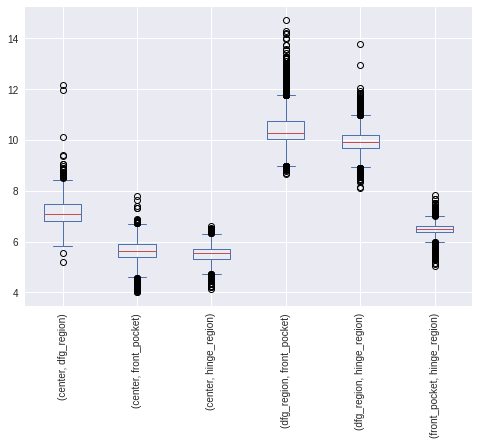

In [11]:
distances.plot(kind="box", rot=90);

In [12]:
distances_stats = pd.concat([distances.std(), distances.mean()], axis=1)
distances_stats.columns = ["std", "mean"]
distances_stats

std       mean
center       dfg_region    0.489319   7.142334
             front_pocket  0.441954   5.639879
             hinge_region  0.323801   5.505672
dfg_region   front_pocket  0.820190  10.533081
             hinge_region  0.552391  10.024428
front_pocket hinge_region  0.297401   6.446958

In [13]:
distances_stats = distances_stats.reset_index()

distances_stats_1 = distances_stats.copy()
distances_stats_1 = distances_stats_1.rename(
    columns={"level_0": "subpocket 1", "level_1": "subpocket 2"}
)
distances_stats_2 = distances_stats.copy()
distances_stats_2 = distances_stats_2.rename(
    columns={"level_1": "subpocket 1", "level_0": "subpocket 2"}
)

distances_stats = pd.concat([distances_stats_1, distances_stats_2])
distances_stats

subpocket 1   subpocket 2       std       mean
0        center    dfg_region  0.489319   7.142334
1        center  front_pocket  0.441954   5.639879
2        center  hinge_region  0.323801   5.505672
3    dfg_region  front_pocket  0.820190  10.533081
4    dfg_region  hinge_region  0.552391  10.024428
5  front_pocket  hinge_region  0.297401   6.446958
0    dfg_region        center  0.489319   7.142334
1  front_pocket        center  0.441954   5.639879
2  hinge_region        center  0.323801   5.505672
3  front_pocket    dfg_region  0.820190  10.533081
4  hinge_region    dfg_region  0.552391  10.024428
5  hinge_region  front_pocket  0.297401   6.446958

### Intra-subpocket distances to reference structure

In [14]:
subpocket_centers = fingerprint_generator.subpocket_centers
subpocket_names = subpocket_centers.columns.get_level_values("subpocket").unique()
structure_klifs_ids = klifs_reference_structures["structure.klifs_id"].to_list()

distances = {}

for subpocket_name in subpocket_names:
    distances[subpocket_name] = {}
    for structure_klifs_id in structure_klifs_ids:
        a = subpocket_centers[subpocket_name].drop(structure_klifs_id)
        b = subpocket_centers[subpocket_name].loc[structure_klifs_id, :]
        difference = a - b
        distance = difference.dropna().apply(lambda x: np.linalg.norm(x), axis=1)
        distances[subpocket_name][structure_klifs_id] = distance
    distances[subpocket_name] = pd.DataFrame(distances[subpocket_name])

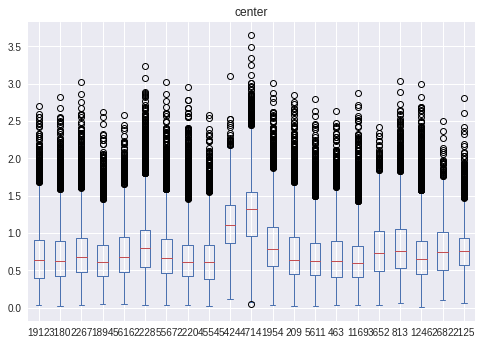

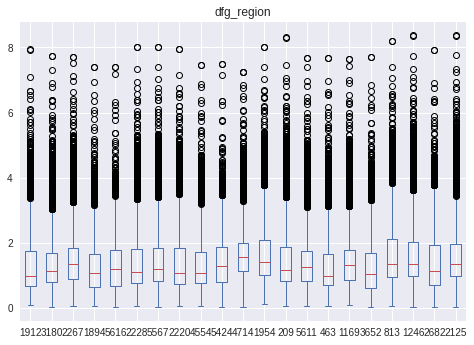

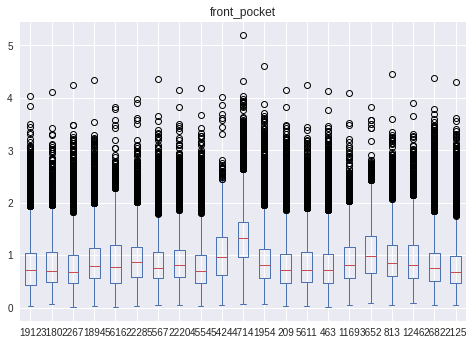

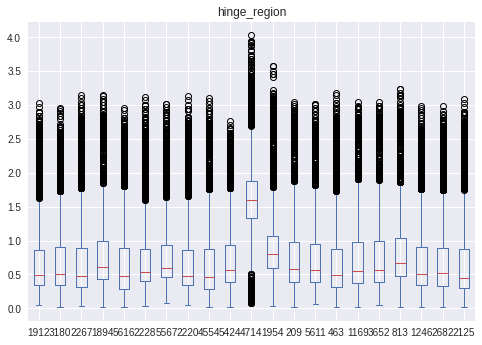

In [15]:
for subpocket_name in subpocket_names:
    distances[subpocket_name].plot(kind="box", title=subpocket_name)

In [16]:
# Get mean of each reference structure's std
distances_stats_intra = []
for subpocket_name in subpocket_names:
    distance_std = distances[subpocket_name].std().mean()
    distance_mean = distances[subpocket_name].mean().mean()
    distances_stats_intra.append([subpocket_name, subpocket_name, distance_std, distance_mean])
distances_stats_intra = pd.DataFrame(
    distances_stats_intra, columns=["subpocket 1", "subpocket 2", "std", "mean"]
)

### Heatmap for inter- and intra-subpocket distances (mean/std)

In [17]:
distances_stats = pd.concat([distances_stats, distances_stats_intra]).reset_index(drop=True)
distances_stats

subpocket 1   subpocket 2       std       mean
0         center    dfg_region  0.489319   7.142334
1         center  front_pocket  0.441954   5.639879
2         center  hinge_region  0.323801   5.505672
3     dfg_region  front_pocket  0.820190  10.533081
4     dfg_region  hinge_region  0.552391  10.024428
5   front_pocket  hinge_region  0.297401   6.446958
6     dfg_region        center  0.489319   7.142334
7   front_pocket        center  0.441954   5.639879
8   hinge_region        center  0.323801   5.505672
9   front_pocket    dfg_region  0.820190  10.533081
10  hinge_region    dfg_region  0.552391  10.024428
11  hinge_region  front_pocket  0.297401   6.446958
12        center        center  0.385966   0.782310
13    dfg_region    dfg_region  0.978924   1.479268
14  front_pocket  front_pocket  0.546326   0.927148
15  hinge_region  hinge_region  0.566249   0.789302

In [18]:
distances_std_pivot = distances_stats.drop("mean", axis=1).pivot(
    columns="subpocket 1", index="subpocket 2", values="std"
)
distances_std_pivot

subpocket 1     center  dfg_region  front_pocket  hinge_region
subpocket 2                                                   
center        0.385966    0.489319      0.441954      0.323801
dfg_region    0.489319    0.978924      0.820190      0.552391
front_pocket  0.441954    0.820190      0.546326      0.297401
hinge_region  0.323801    0.552391      0.297401      0.566249

In [19]:
distances_mean_pivot = distances_stats.drop("std", axis=1).pivot(
    columns="subpocket 1", index="subpocket 2", values="mean"
)
# Reverse column names to that they overlay with the heatmap
reversed_column_names = distances_mean_pivot.columns.to_list()[::-1]
distances_mean_pivot = distances_mean_pivot.loc[reversed_column_names, reversed_column_names]
distances_mean_pivot

subpocket 1   hinge_region  front_pocket  dfg_region    center
subpocket 2                                                   
hinge_region      0.789302      6.446958   10.024428  5.505672
front_pocket      6.446958      0.927148   10.533081  5.639879
dfg_region       10.024428     10.533081    1.479268  7.142334
center            5.505672      5.639879    7.142334  0.782310

Text(51.0, 0.5, '')

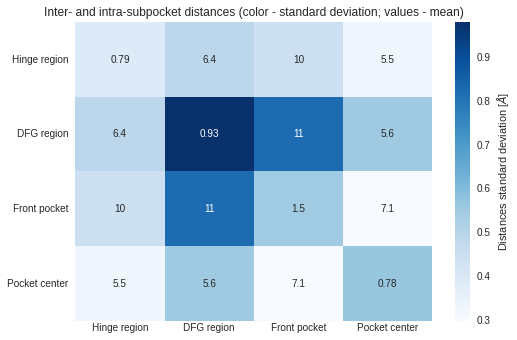

In [20]:
sns.heatmap(
    distances_std_pivot,
    cmap="Blues",
    annot=distances_mean_pivot,
    cbar_kws={"label": "Distances standard deviation [$\AA$]"},  # noqa: W605
)
labels = ["Hinge region", "DFG region", "Front pocket", "Pocket center"]
plt.title("Inter- and intra-subpocket distances (color - standard deviation; values - mean)")
plt.xticks(np.arange(4) + 0.5, (labels), rotation=0, va="center")
plt.yticks(np.arange(4) + 0.5, (labels), rotation=0, va="center")
plt.xlabel("")
plt.ylabel("")
# sns.set(font_scale=2)

Key takeaways:

- Distance mean
  - Pocket center, hinge region, and front pocket are about equally spaced from each other (~6A)
  - DFG region is a bit further away (closer to pocket center than to hinge region and front pocket)
- Distance standard deviation
  - Standard deviations are all below 1A
  - DFG subpocket shows most variation (w.r.t. DFG conformations), followed by the front pocket (w.r.t. flexible p-loop)


### Show example structure with subpockets

Let's show an example structure with subpockets to make sense of the mean distances that we have calculated.

In [21]:
SUBPOCKETS

{'anchor_residue.klifs_ids': [[16, 47, 80], [19, 24, 81], [10, 48, 72]],
 'subpocket.name': ['hinge_region', 'dfg_region', 'front_pocket'],
 'subpocket.color': ['magenta', 'cornflowerblue', 'green']}

In [22]:
pocket = PocketKlifs.from_structure_klifs_id(3652, SUBPOCKETS)

In [23]:
subpocket_coords = (
    pocket.subpockets[["subpocket.name", "subpocket.center"]].set_index("subpocket.name").squeeze()
)
subpocket_coords = pd.concat(
    [subpocket_coords, pd.Series([pocket.center.tolist()], index=["center"])]
)

distances_example_structure = {}
subpocket_pairs = itertools.combinations(subpocket_coords.index, 2)
for subpocket_pair in subpocket_pairs:
    difference = subpocket_coords[subpocket_pair[0]] - subpocket_coords[subpocket_pair[1]]
    distance = np.linalg.norm(difference)
    distances_example_structure[subpocket_pair] = distance
distances_example_structure

{('hinge_region', 'dfg_region'): 9.955494,
 ('hinge_region', 'front_pocket'): 6.3870726,
 ('hinge_region', 'center'): 5.538795222621422,
 ('dfg_region', 'front_pocket'): 10.053213,
 ('dfg_region', 'center'): 7.183169918155383,
 ('front_pocket', 'center'): 5.249160890296896}

In [24]:
viewer = PocketViewer()
viewer.add_pocket(pocket)
viewer.viewer

NGLWidget()

In [25]:
viewer.viewer.render_image(trim=True, factor=1, transparent=True);

In [26]:
viewer.viewer._display_image()

## Superimpose random structures with their subpocket centers

In [27]:
N_RANDOM_STRUCTURES = 20

In [28]:
structure_klifs_ids = list(fingerprint_generator.data.keys())
structure_klifs_ids_random = random.sample(structure_klifs_ids, N_RANDOM_STRUCTURES)

In [29]:
print(*structure_klifs_ids_random)

4303 5310 1493 7322 11269 723 3662 2436 884 7338 2431 4389 5395 6543 1884 10389 3021 2830 718 13740


In [30]:
viewer = PocketViewer()
for structure_klifs_id in structure_klifs_ids_random:
    pocket = PocketKlifs.from_structure_klifs_id(structure_klifs_id, SUBPOCKETS)
    viewer.add_pocket(pocket, show_only_pocket_residues=True)
viewer.viewer  # .display(gui=True)

NGLWidget()

In [31]:
viewer.viewer.render_image(trim=True, factor=1, transparent=True);

In [32]:
viewer.viewer._display_image()

In [33]:
viewer = PocketViewer()
for structure_klifs_id in structure_klifs_ids_random:

    pocket = PocketKlifs.from_structure_klifs_id(structure_klifs_id, SUBPOCKETS)

    viewer.add_pocket(pocket, show_only_pocket_residues=True)
    component_ix = viewer._components_structures[structure_klifs_id]
    selection = " or ".join(viewer.pockets_residue_ngl_ixs[pocket.name])

    viewer.viewer.clear_representations(component_ix)
    viewer.viewer.add_representation(
        "cartoon", selection=selection, component=component_ix, opacity=0.1
    )
viewer.viewer.display(gui=True)

ThemeManager()

NGLWidget(gui_style='ngl')

In [34]:
viewer.viewer.render_image(trim=True, factor=1, transparent=True);

In [35]:
viewer.viewer._display_image()